# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [5]:
import pandas as pd
from matplotlib.pyplot import boxplot
import numpy as np
from scipy. stats import boxcox
from matplotlib import pyplot
import statsmodels.api as sm
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [6]:
train_df = pd.read_csv('/datasets/hotel_train.csv')
test_df  = pd.read_csv('/datasets/hotel_test.csv')

# 1. Предобработка и исследовательский анализ данных

## 1.1 Предобработка данных 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

изменим тип данных столбцов 'lead_time', 'adults', 'children', 'babies' с float на int

In [9]:
for col in ['lead_time', 'adults', 'children', 'babies']:
    train_df[col] = train_df[col].astype('int64')
    test_df[col] = test_df[col].astype('int64')

проверим наличие дубликатов записи по id

In [10]:
print('train_df: ', len(train_df['id'].unique()))
print('test_df: ', len(test_df['id'].unique()))

train_df:  65229
test_df:  32412


явынх дубликатов записей нету

проверим на наличие неявных дубликатов

In [11]:
def found_dublicate(data):
    for col in data.select_dtypes(include=['object']).columns:
        print('==============', col, '=====================')
        print(data.groupby(by = col).count()['id'])
        print('=============================================')

для train_df

In [12]:
found_dublicate(train_df)

============== arrival_date_month =====================
arrival_date_month
April        4804
August       6678
December     5497
February     3358
January      1892
July         5718
June         4659
March        4148
May          4677
November     5761
October      9255
September    8782
Name: id, dtype: int64
============== meal =====================
meal
BB           51697
FB             451
HB            7292
SC             515
SC            5274
Name: id, dtype: int64
============== country =====================
country
ABW      1
AGO    140
ALB      7
AND      1
ARE     26
      ... 
VGB      1
VNM      5
ZAF     36
ZMB      1
ZWE      1
Name: id, Length: 155, dtype: int64
============== distribution_channel =====================
distribution_channel
Corporate     3823
Direct        6853
GDS             99
TA/TO        54454
Name: id, dtype: int64
============== reserved_room_type =====================
reserved_room_type
A                   50501
B                     860
C     

для test_df

In [13]:
found_dublicate(test_df)

============== arrival_date_month =====================
arrival_date_month
April       4878
August      3096
February    3543
January     3150
July        3626
June        4580
March       4277
May         5262
Name: id, dtype: int64
============== meal =====================
meal
BB           24684
FB              36
HB            2399
SC             258
SC            5035
Name: id, dtype: int64
============== country =====================
country
ABW     1
AGO    63
ALB     4
AND     1
ARE    11
       ..
UZB     3
VEN     5
VNM     3
ZAF    34
ZWE     2
Name: id, Length: 143, dtype: int64
============== distribution_channel =====================
distribution_channel
Corporate     1602
Direct        3642
GDS             85
TA/TO        27083
Name: id, dtype: int64
============== reserved_room_type =====================
reserved_room_type
A                   23471
B                     192
C                     201
D                    6123
E                    1644
F                  

наличие явных дубликатов в столбцах в обиех таблицах с небольшим разнообразием вариантов записей не обнаружено. В стобце country записей слишком много для анализа

В некоторых данных возмодны пробелы. Удалим их

In [14]:
def drop_whitespaces(data):
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].str.strip()

In [15]:
drop_whitespaces(train_df)
drop_whitespaces(test_df)

### 1.2 Исследовательский анализ

<b>Для исследовательского анализа сформулируем несколько гипотез.</b><br>

### Гипотезы

<b>Гипотеза 1.</b> - Люди, которые отменяли бронь, ожидали поддтверждения закза дольше, чем люди, которые бронь не отменяли<br>

<b> Гипотеза 2.</b> - Процент отмененных заказов зависит от цены на номер.

<b>Гипотеза 3.</b> - Вероятность отмены брони зависит от количество дней между датой бронирования и датой прибытия:
Возможно люди которые бронируеют на несколько месяцев вперед находят более лучшие предложения в других отелях и отменяют бронь в этом

<b>Гипотеза 4</b>. - Вероятность отмены брони зависит от количество ранее отмененных заказов у клиента

<b>Гипотеза 5</b>. - Вероятность отмены брони зависит от то, бронирует ли клиент повторно или нет

### 1.2.1 Борьба с выбросами

для начала найдем выбросы для 'adults', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights', 'total_of_special_requests' и удалим их

In [16]:
list_for_anomal = ['adults', 'babies', 'booking_changes', 
                  'children', 'days_in_waiting_list', 'lead_time', 
                  'previous_bookings_not_canceled', 'previous_cancellations', 
                  'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights', 
                  'total_of_special_requests']

для train_df

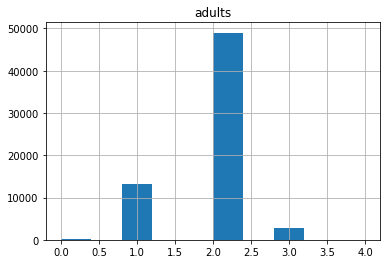

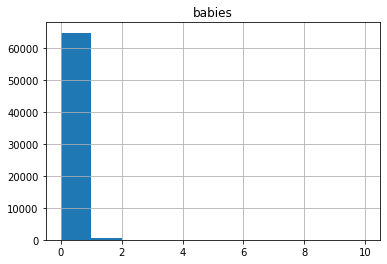

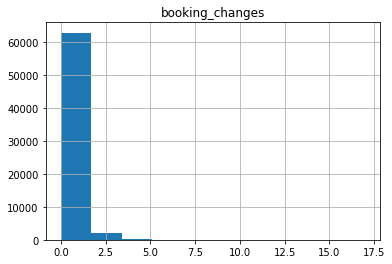

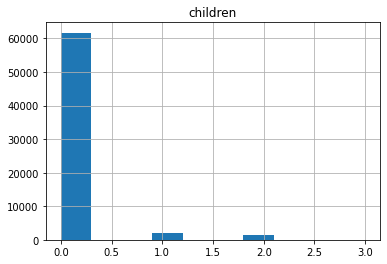

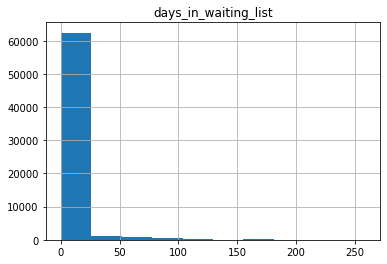

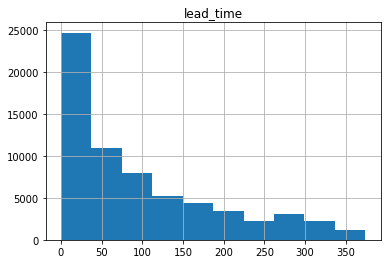

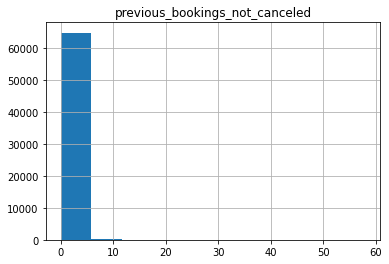

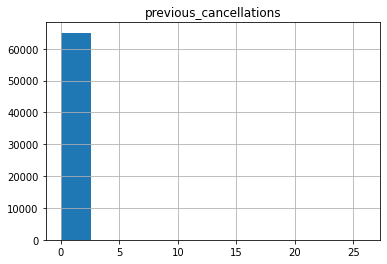

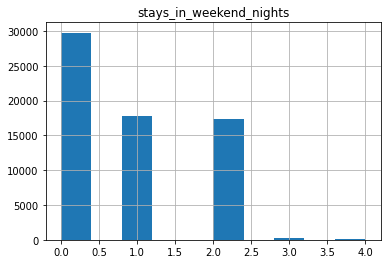

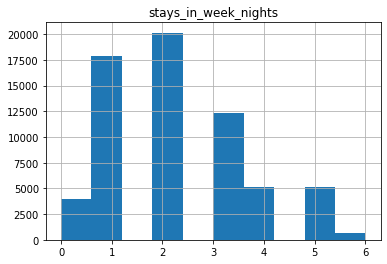

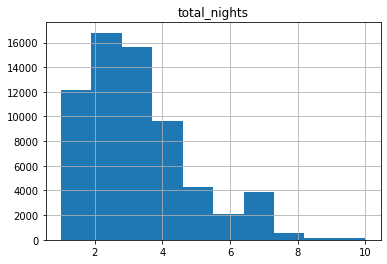

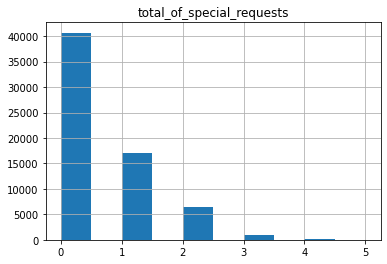

In [17]:
for col in list_for_anomal:
    train_df.hist(column=col)

In [18]:
for col in list_for_anomal:
    print('============ train', col, '========================')
    print(train_df[col].describe())
    print('================================================')

============ train adults ========================
count    65229.000000
mean         1.836576
std          0.480245
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: adults, dtype: float64
============ train babies ========================
count    65229.000000
mean         0.007236
std          0.098790
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: babies, dtype: float64
============ train booking_changes ========================
count    65229.000000
mean         0.194269
std          0.593838
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: booking_changes, dtype: float64
============ train children ========================
count    65229.000000
mean         0.074890
std          0.334243
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max    

имеются выбросы в babies, booking_changes, days_in_waiting_list, previous_bookings_not_canceled, previous_cancellations

для test_df

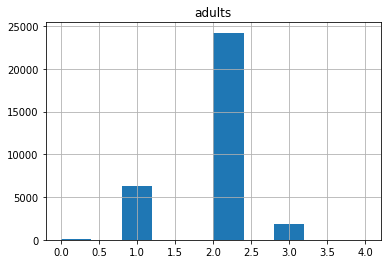

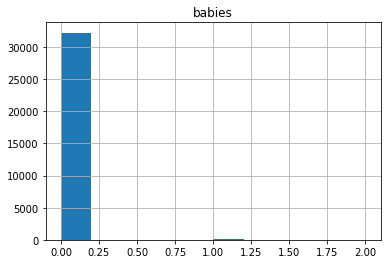

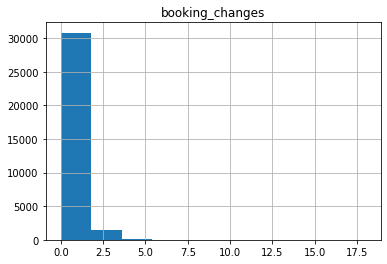

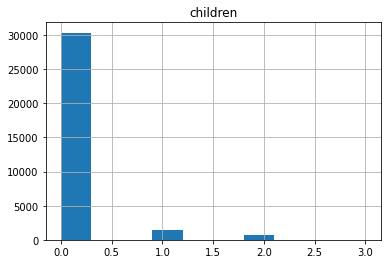

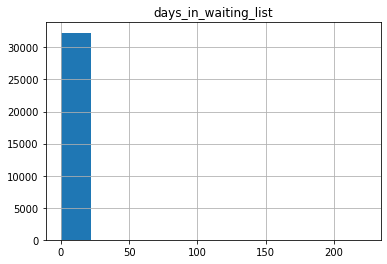

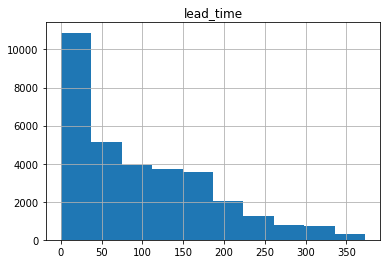

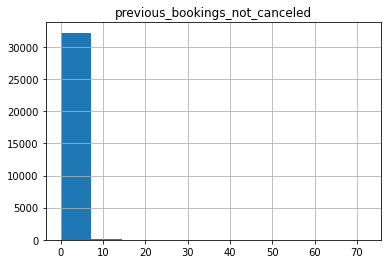

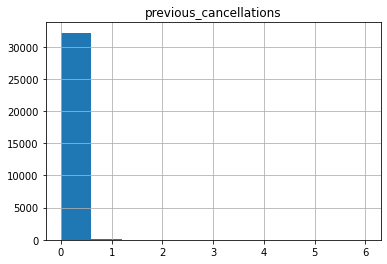

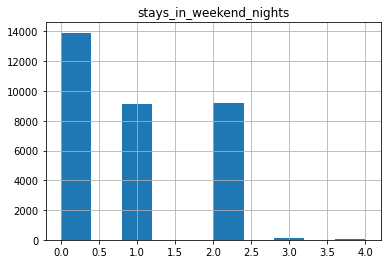

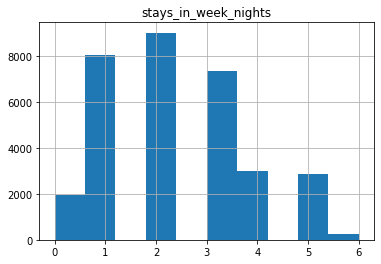

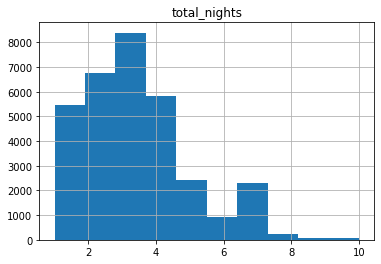

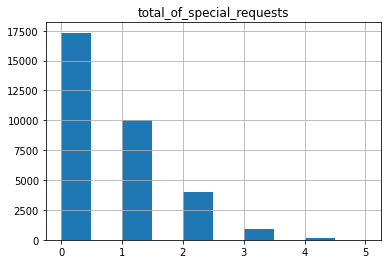

In [19]:
for col in list_for_anomal:
    test_df.hist(column=col)

In [20]:
for col in list_for_anomal:
    print('============ test', col, '========================')
    print(test_df[col].describe())
    print('================================================')

============ test adults ========================
count    32412.000000
mean         1.858602
std          0.489341
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: adults, dtype: float64
============ test babies ========================
count    32412.000000
mean         0.005523
std          0.075757
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: babies, dtype: float64
============ test booking_changes ========================
count    32412.000000
mean         0.216741
std          0.640551
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: booking_changes, dtype: float64
============ test children ========================
count    32412.000000
mean         0.083765
std          0.343470
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        

в test_df выбросы есть в booking_changes, days_in_waiting_list, previous_bookings_not_canceled, 

<b>babies

In [21]:
len(train_df.loc[train_df['babies'] > 2])

2

In [22]:
train_df = train_df.loc[train_df['babies'] <= 2]

<b>booking_changes

In [23]:
len(train_df.loc[train_df['booking_changes'] > 3])

252

In [24]:
len(test_df.loc[test_df['booking_changes'] > 3])

174

In [25]:
train_df = train_df.loc[train_df['booking_changes'] < 3]
test_df = test_df.loc[test_df['booking_changes'] < 3]

<b>days_in_waiting_list

In [26]:
len(train_df.loc[train_df['days_in_waiting_list'] > 3])

3133

In [27]:
len(test_df.loc[test_df['days_in_waiting_list'] > 3])

165

In [28]:
train_df = train_df.loc[train_df['days_in_waiting_list'] < 3]
test_df = test_df.loc[test_df['days_in_waiting_list'] < 3]

<b> previous_bookings_not_canceled

In [29]:
len(train_df.loc[train_df['previous_bookings_not_canceled'] >= 5])

382

In [30]:
len(test_df.loc[test_df['previous_bookings_not_canceled'] >= 5])

316

In [31]:
train_df = train_df.loc[train_df['previous_bookings_not_canceled'] < 5]
test_df = test_df.loc[test_df['previous_bookings_not_canceled'] < 5]

<b> previous_cancellations

In [32]:
len(train_df.loc[train_df['previous_cancellations'] > 26])

0

In [33]:
len(test_df.loc[test_df['previous_cancellations'] == 26])

0

Для исследовательского анализа объеденим train и test

In [34]:
all_data = pd.concat([train_df, test_df])

### 1.2.2 Проверка гипотеза 1

<b>Люди, которые отменяли бронь, ожидали поддтверждения закза дольше, чем люди, которые бронь не отменяли<br>

In [35]:
all_data['total_nights'].describe()

count    92477.000000
mean         3.116137
std          1.753478
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: total_nights, dtype: float64

In [36]:
cancaled_offers = all_data.loc[all_data['is_canceled'] == 1]
not_cancaled_offers = all_data.loc[all_data['is_canceled'] == 0]

Посмотрим время подтверждения брони для отмененнных саказов

<AxesSubplot:>

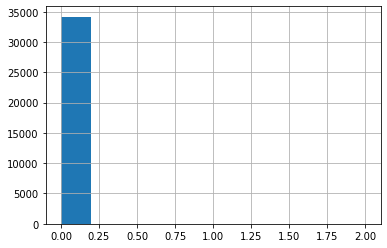

In [37]:
cancaled_offers['days_in_waiting_list'].hist()

In [38]:
days = cancaled_offers.loc[cancaled_offers['days_in_waiting_list'] != 0]['id'].count()
print('количество когда бронь была подтверждена больше чем за 0 дней для отмененных заказов:', days)

количество когда бронь была подтверждена больше чем за 0 дней для отмененных заказов: 2


<AxesSubplot:>

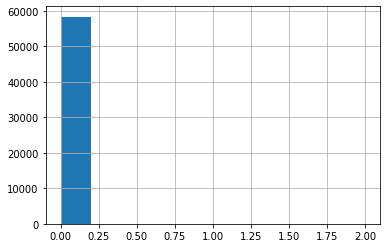

In [39]:
not_cancaled_offers['days_in_waiting_list'].hist()

In [40]:
days = not_cancaled_offers.loc[not_cancaled_offers['days_in_waiting_list'] != 0]['id'].count()
print('количество когда бронь была подтверждена больше чем за 0 дней для не отмененных заказов:', days)

количество когда бронь была подтверждена больше чем за 0 дней для не отмененных заказов: 7


### Вывод по гипотезе 1.

количество дней ожидания подтверждения брони, что для отмененных заказов, что для не отмененных заказов одинакво. В отмененных заказах бронирование только 2 раза пожтверждаось больше, чем за 0 дней. Для не отмененных заказов было лишь 7 случая, когда бронь ожидала подтверждения больше 0 дней<br>
<b> Итог:<br></b>
Люди, которые отменяли бронь, <b>не</b> ожидали поддтверждения закза дольше, чем люди, которые бронь не отменяли. Нарборот, люди, которые бронь не отмения иногда ждали дольше, чем люди отменившие бронь. Также можно добавить, что время ожидания подтверждения брони для отмененных заказов и не отмененных равны с небольшой погрешностью.<br>
<b>Гипотеза 1 - ОПРОВЕРГНУТО!<b>

### 1.2.3 Проверка гипотеза 2.

<b>Вероятность того, что бронь будет отменена зависит от типа номера.</b>

In [41]:
def add_room_price(col):
    if col == 'A':
        return 1000
    
    elif col == 'B':
        return 800
    
    elif col == 'C':
        return 600
    
    elif col == 'D':
        return 550
    
    elif col == 'E':
        return 500
    
    elif col == 'F':
        return 450
    
    else:
        return 350
    
    

In [42]:
def correlation(x_data, y_data):
    result = pearsonr(x_data, y_data)
    print('coef correlation = ', result.statistic)
    print('p-value =', result.pvalue)
    
    if result.pvalue > 0.05:
        print('стaтистически НЕзначемый коэфицент')
    
    else:
        print('стaтистически значемый коэфицент')

In [43]:
data_hypotis_2 = all_data[['reserved_room_type', 'is_canceled']]
data_hypotis_2['room_price'] = data_hypotis_2['reserved_room_type'].apply(add_room_price)

/tmp/ipykernel_97/4120665076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hypotis_2['room_price'] = data_hypotis_2['reserved_room_type'].apply(add_room_price)


In [44]:
canceled = data_hypotis_2.loc[data_hypotis_2['is_canceled'] == 1]

In [45]:
canceled_offers = canceled.groupby(by='room_price').count()['is_canceled']

In [46]:
all_offers = data_hypotis_2.groupby(by='room_price').count()['reserved_room_type']

In [47]:
canceled_percent = canceled_offers/all_offers

In [48]:
canceled_percent_data = pd.DataFrame(data={'price': all_offers.index,
                                              'canceled_percent': canceled_percent.values})
canceled_percent_data

,price,canceled_percent
0,350,0.352941
1,450,0.300239
2,500,0.289851
3,550,0.325044
4,600,0.316953
5,800,0.326108
6,1000,0.386615


<AxesSubplot:>

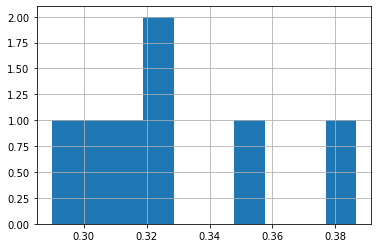

In [49]:
canceled_percent_data['canceled_percent'].hist()

Посмотри на зависимость процента отменены брони и цены комнаты

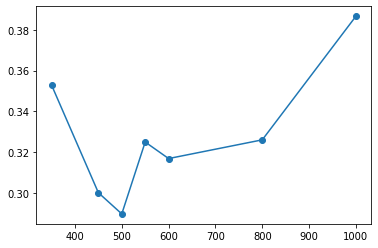

In [50]:
plt.plot(canceled_percent_data['price'], canceled_percent_data['canceled_percent'], '-o')
plt.show()

In [51]:
correlation(canceled_percent_data['price'], canceled_percent_data['canceled_percent'])

coef correlation =  0.5712687888207431
p-value = 0.18035193787044268
стaтистически НЕзначемый коэфицент


### Вывод по гипотезе 2

прямой линейной зависимотси между процентом отмененных бронирований и ценой за номер нету.Так же имеется коэфицент корреляции пирсона равный ~ 0.57 и имеющий p-value ~ 0.18, что длеат коэфицент статистически не значемым. Вроятности отмены брони ддля каждый цены распределены равномерно и в диапозоне от 0.28 до 0.38. Оданко самая низкая вероятность отмееы брони у клиентов, которые бронировали номер класса 'E'<br>
<b> У нас не достаточно оснований для отклонения гипотезы 2.</b>

### 1.2.4 Проверка гипотеза 3

<b>Проверка Гипотезы 3. </b> - Вероятность отмены брони зависит от количество дней между датой бронирования и датой прибытия:<br>
Возможно люди которые бронируеют на несколько месяцев вперед находят более лучшие предложения в других отелях и отменяют бронь в этом

In [52]:
def check_for_normal(data):
    plt = sm.qqplot(data, line='45')
    plt.show()
    
    result = shapiro(data)
    print(result.pvalue)
    if result.pvalue > 0.05:
        print('у нас не достаточно оснований отвергнуть H0. Данные распределены НОРМАЛЬНО')
        
    else:
        print('у нас не достаточно оснований принять H0. Данные  НЕ распределены НОРМАЛЬНО')

In [53]:
data_hypotis_3 = all_data[['lead_time', 'is_canceled']]
canceled = data_hypotis_3.loc[data_hypotis_3['is_canceled'] == 1]
canceled_offers = canceled.groupby(by='lead_time').count()['is_canceled']
all_offers = data_hypotis_3.groupby(by='lead_time').count()['is_canceled']
canceled_percent = canceled_offers/all_offers
canceled_percent_data = pd.DataFrame(data={'lead_time': all_offers.index,
                                              'canceled_percent': canceled_percent.values})

In [54]:
canceled_percent_data = canceled_percent_data.dropna()

In [55]:
canceled_percent_data.loc[canceled_percent_data['canceled_percent'] == canceled_percent_data['canceled_percent'].min()]

,lead_time,canceled_percent
0,0,0.067808


In [56]:
canceled_percent_data

,lead_time,canceled_percent
0,0,0.067808
1,1,0.099925
2,2,0.106490
3,3,0.103026
4,4,0.106141
...,...,...
367,367,0.909091
368,368,0.805556
369,372,1.000000
370,373,0.964286


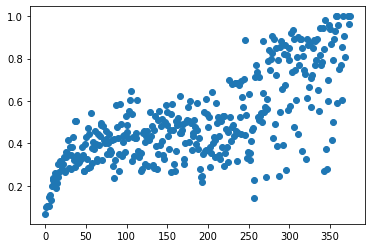

In [57]:
plt.scatter(x = canceled_percent_data['lead_time'], y = canceled_percent_data['canceled_percent'])

Проведем регрессионный анализ

In [58]:
correlation(canceled_percent_data['lead_time'], canceled_percent_data['canceled_percent'])

coef correlation =  0.7229059293210816
p-value = 3.2581511448807986e-61
стaтистически значемый коэфицент


можно заметить большую положительную корреляция между переменными

In [59]:
Y = canceled_percent_data['canceled_percent']
X = canceled_percent_data['lead_time']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       canceled_percent   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     403.9
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           3.26e-61
Time:                        17:03:44   Log-Likelihood:                 193.08
No. Observations:                 371   AIC:                            -382.2
Df Residuals:                     369   BIC:                            -374.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2440      0.015     16.340      0.000       0.215       0.273
lead_time      0.0014   6.98e-05     20.098      0.000       0.001       0.002
==============================================================================
Omnibus:                       15.022   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.713
Skew:                          -0.491   Prob(JB):                     0.000387
Kurtosis:                       3.227   Cond. No.                         427.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.2440 и 0.0014 - статистически значенмые коэфиценты, что говрит p-value < 0.05 для обоих коэфицентов, следовательно гипотезы H0: для обеих переменных, что b0 = 0 и b1 = 0 не были приняты. R^2 = 0.523

<AxesSubplot:xlabel='lead_time', ylabel='canceled_percent'>

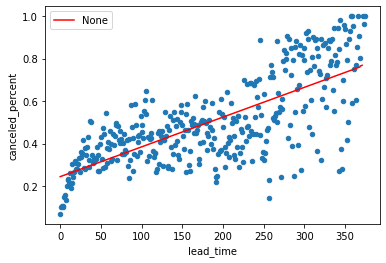

In [60]:
canceled_percent_data.plot(x='lead_time', y='canceled_percent', kind='scatter', legend=True)
model.predict(X).plot(color='r', legend=True)

Проверим модель на гомоскедастичность

Посмотрим на распределение остатков

In [61]:
remains = model.resid

count    3.710000e+02
mean     6.104730e-17
std      1.439898e-01
min     -4.605189e-01
25%     -8.901292e-02
50%      1.196167e-02
75%      1.016275e-01
max      3.002631e-01
dtype: float64

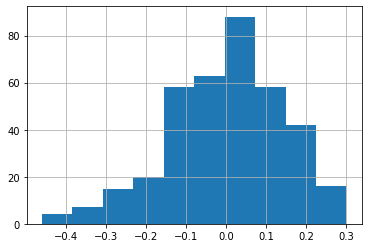

In [62]:
remains.hist()
remains.describe()

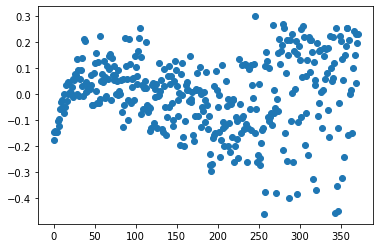

In [63]:
plt.scatter(x=remains.index, y=remains.values)

0.00010274296073475853
у нас не достаточно оснований принять H0. Данные  НЕ распределены НОРМАЛЬНО


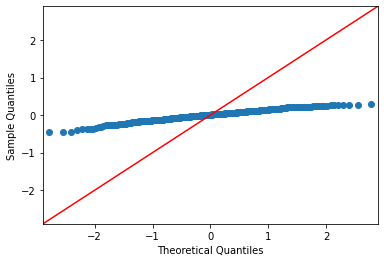

In [64]:
check_for_normal(remains)

<b>Итог регрессионного анализа<br></b>
Была найдена статистически значемый коэфицент корреляции = 0.72. Однако, описать зависимость уравнением вида:<br>
cancel_probability = 0.2440 + 0.0014 * lead_time не удалось из-за отсютсвия гомоскедастичности. Четкой зависимости между переменными не обнаружено

### Вывод по гипотезе 3


Четкой зависимости между вероятностью отмены брони количеством дней между датой бронирования и датой прибытия не обнаружено, делать точный прогноз определяющий вероятность отмены не предостовляется возможным. Однако стоит обратить внимание на положительную корреляцию. Можно сделать вывод, что чем больше количество дней между датой бронирования и датой прибытия, тем больше вероятность отмены брони. Так же самая низкая вероятность отмены брони у клиентов, у которых   количество дней между датой бронирования и датой прибытия равна 0<br>
<b> Гипотеза 3 - ПОДТВЕРЖДЕНО</b>

### 1.2.5 Проверка гипотеза 4

<b>Вероятность отмены брони зависит от количество ранее отмененных заказов у клиента</b>

In [65]:
data_hypotis_4 = all_data[['is_canceled', 'previous_cancellations']]

In [66]:
data_hypotis_4 = all_data[['is_canceled', 'previous_cancellations']]
canceled = data_hypotis_4.loc[data_hypotis_4['is_canceled'] == 1]

canceled_offers = canceled.groupby(by='previous_cancellations').count()['is_canceled']
all_offers = data_hypotis_4.groupby(by='previous_cancellations').count()['is_canceled']
canceled_percent = canceled_offers/all_offers

canceled_percent_data = pd.DataFrame(data={'previous_cancellations': all_offers.index,
                                              'canceled_percent': canceled_percent.values})


In [67]:
canceled_percent_data['canceled_percent'] = canceled_percent_data['canceled_percent'].fillna(0)

In [68]:
canceled_percent_data

,previous_cancellations,canceled_percent
0,0,0.336311
1,1,0.979789
2,2,0.666667
3,3,0.705882
4,4,0.500000
5,5,0.333333
6,11,0.153846
7,13,0.000000
8,14,1.000000
9,19,1.000000


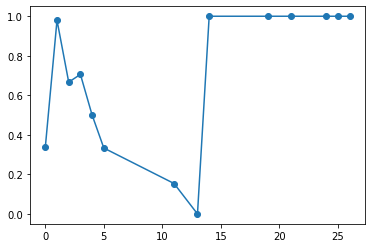

In [69]:
plt.plot(canceled_percent_data['previous_cancellations'], canceled_percent_data['canceled_percent'], '-o')
plt.show()

In [70]:
canceled['previous_cancellations'].value_counts()

0     29483
1      4557
24       28
2        20
25       19
26       18
19       17
3        12
14       11
11        2
4         1
5         1
21        1
Name: previous_cancellations, dtype: int64

рассмотрим данные когда человек бронирует повторно 0 и 1 раз, так как информации об остальном количестве бронирования крайне мало 

In [71]:
canceled_percent_data.head(2)

,previous_cancellations,canceled_percent
0,0,0.336311
1,1,0.979789


видно, что очень большой процент отмененных заказов, если у человека уже есть ранее отмененный заказ

### Вывод по гипотезе 4

Найден очень выскойи процент отмены брони, если у клиента уже имеется 1 отмененный заказ - 0.97. Однако имеется большой дисбаланс в данных. Данных, о случаях, когда 0 отмененных заказов - 29483, Данных, о случаях, когда 1 отмененный заказ - 4557. Из-за этого выскокая вероятность не репрезентативности данных<br>
<b> Гипотеза 4 - НЕДОСТАТОЧНО ОСНОВАНИЙ ДЛЯ ПРИНЯТИЯ</b>

### 1.2.6 Проверка гипотеза 5

<b>Вероятность отмены брони зависит от то, бронирует ли клиент повторно или нет</b>

In [72]:
data_hypotis_5 = all_data[['is_canceled', 'is_repeated_guest']]

canceled = data_hypotis_5.loc[data_hypotis_5['is_canceled'] == 1]
canceled_offers = canceled.groupby(by='is_repeated_guest').count()['is_canceled']

all_offers = data_hypotis_5.groupby(by='is_repeated_guest').count()['is_canceled']
canceled_percent = canceled_offers/all_offers

canceled_percent_data = pd.DataFrame(data={'is_repeated_guest': all_offers.index,
                                              'canceled_percent': canceled_percent.values})

canceled_percent_data

,is_repeated_guest,canceled_percent
0,0,0.373199
1,1,0.211348


In [73]:
canceled['is_repeated_guest'].value_counts()

0    33723
1      447
Name: is_repeated_guest, dtype: int64

Слишком мало данных об информации, когда человек бронирует повторно - 447.

### Вывод по гипотезе 5

Найдена разница между процентом отмененной брони, когда клиент бронирует повторно и когда не бронирует повторно. Вероятность отмены брони, если человек бронирует потворно - 0.21. Вероятность отмены брони, если человек НЕ бронирует потворно - 0.37. Разница не столь велика, но имеется. Однако данныз слишком мало.<br>
<b>Гипотеза 5 - НЕДОСТАТОЧНО ОСНОВАНИЙ ДЛЯ ПРИНЯТИЯ</b>

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: классный исследовательский анализ!</div>

# 2. Формулировка ML-задачи на основе бизнес-задачи

### Формулирование задачи

Для минимизации убытков разработать модель, котороя будет предсказывть возможную отмену бронирования нмоера в отели, тем самым минимизурая риск на убыток. Внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании. Бюджет на разработку модели = 400 000 рублей

#### Вспомогательные функции

In [74]:
def add_clining_cost(col):

    if col == 'A':
        return 400
    
    elif col == 'B' or col == 'C':
        return 350
    
    else:
        return 150

##### Функция подсчета прибыли

In [75]:
import math
def proffit_calculation(row):

    count_of_cleaning = 1 + row['total_nights'] // 2
    
    expenses_for_cleaning = row['clining_cost'] * count_of_cleaning
    
    
    if row['arrival_date_month'] in ['July', 'August', 'June']:
        revenue = (row['room_price'] * 1.4) * row['total_nights']
        
        if row['is_canceled'] == 1:
            return -((row['room_price'] * 1.4) + row['clining_cost'])
        
        elif row['is_canceled'] == 0:
            return revenue - expenses_for_cleaning
    
    
    elif row['arrival_date_month'] in ['November', 'October', 'September', 'May', 'April', 'March']:
        revenue = (row['room_price'] * 1.2) * row['total_nights']
        
        if row['is_canceled'] == 1:
            return -((row['room_price'] * 1.2) + row['clining_cost'])
        
        elif row['is_canceled'] == 0:
            return revenue - expenses_for_cleaning
    
    
    else:
        revenue = row['room_price'] * row['total_nights']
        if row['is_canceled'] == 1:
            return -(row['room_price'] + row['clining_cost'])
        
        elif row['is_canceled'] == 0:
            return revenue - expenses_for_cleaning

##### Создание таблицы для посчета выручки, прибыли и убытка       

In [76]:
proffit_data = train_df[['is_canceled', 'reserved_room_type', 'arrival_date_month', 'total_nights', 'arrival_date_year']]
proffit_data = proffit_data.loc[proffit_data['arrival_date_year'] == 2016]
proffit_data['room_price'] = proffit_data['reserved_room_type'].apply(add_room_price)
proffit_data['clining_cost'] = proffit_data['reserved_room_type'].apply(add_clining_cost)
proffit_data['proffit'] = proffit_data.apply(proffit_calculation, axis=1)

In [77]:
proffit_data

,is_canceled,reserved_room_type,arrival_date_month,total_nights,arrival_date_year,room_price,clining_cost,proffit
2363,1,D,January,1,2016,550,150,-700.0
2364,1,G,January,2,2016,350,150,-500.0
2365,1,A,January,3,2016,1000,400,-1400.0
2366,0,A,January,2,2016,1000,400,1200.0
2367,1,A,January,1,2016,1000,400,-1400.0
...,...,...,...,...,...,...,...,...
65224,0,D,December,6,2016,550,150,2700.0
65225,0,D,December,5,2016,550,150,2300.0
65226,0,D,December,6,2016,550,150,2700.0
65227,0,A,December,7,2016,1000,400,5400.0


## 3.1 Подсчет выручки, прибыли и убытка

In [78]:
revenue = proffit_data.loc[proffit_data['proffit'] >= 0]['proffit'].sum()
loss = proffit_data.loc[proffit_data['proffit'] < 0]['proffit'].sum()
proffit = proffit_data['proffit'].sum()

print('за 2016 год')
print('выручка = ', revenue)
print('убыток = ', loss)
print('прибыль', proffit)

за 2016 год
выручка =  69873390.0
убыток =  -20906710.0
прибыль 48966680.0


# 3. Разработка модели ML

## 3.1 Подготовка данных

### 3.1.1 категоризация стран

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60988 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              60988 non-null  int64 
 1   is_canceled                     60988 non-null  int64 
 2   lead_time                       60988 non-null  int64 
 3   arrival_date_year               60988 non-null  int64 
 4   arrival_date_month              60988 non-null  object
 5   arrival_date_week_number        60988 non-null  int64 
 6   arrival_date_day_of_month       60988 non-null  int64 
 7   stays_in_weekend_nights         60988 non-null  int64 
 8   stays_in_week_nights            60988 non-null  int64 
 9   adults                          60988 non-null  int64 
 10  children                        60988 non-null  int64 
 11  babies                          60988 non-null  int64 
 12  meal                            60988 non-null

<AxesSubplot:>

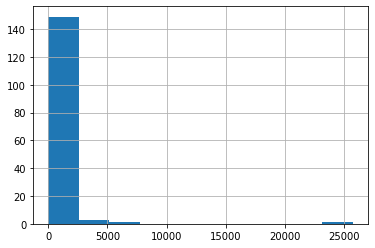

In [80]:
train_df['country'].value_counts().hist()

так как стран очень много, то самые популярные 5 стран выделем отдельно, а остальные запишим как another

In [81]:
train_df['country'].value_counts().head(5).index

Index(['PRT', 'FRA', 'GBR', 'ESP', 'DEU'], dtype='object')

In [82]:
def country_catigories(col):
    if col in ['PRT', 'FRA', 'GBR', 'ESP', 'DEU']:
        return col
    
    else:
        return 'another'

In [83]:
train_df['country'] = train_df['country'].apply(country_catigories)
test_df['country'] = test_df['country'].apply(country_catigories)

### 3.1.2 Разбиение на независимые переменные X и зависимую переменную Y

In [84]:
X_train = train_df.drop(['id', 'is_canceled'], axis=1)
Y_train = train_df['is_canceled']

X_test = test_df.drop(['id', 'is_canceled'], axis=1)
Y_test = test_df['is_canceled']

##### OHE для создания фиктивных переменных

In [85]:
X_categorical = ['meal', 'country', 'distribution_channel', 
                 'customer_type', 'reserved_room_type', 
                 'arrival_date_month']

In [86]:
def ohe_transform(X, X_categorical):
    
    ohe = OneHotEncoder(sparse=False, drop='first')
    ohe.fit(X_train[X_categorical])
    
    X_transform = pd.DataFrame(data = ohe.transform(X[X_categorical]),
                               columns = ohe.get_feature_names_out(),
                               index = X.index)
    
    X = X.drop(X_categorical, axis=1)
    X = X.join(X_transform)
    
    return X

##### Функция Ordinal encoder

In [87]:
def ordinal_encoder(X, X_categorical):
    encoder = OrdinalEncoder()
    encoder.fit(X[X_categorical])
    
    X_transform = pd.DataFrame(data = encoder.transform(X[X_categorical]),
                               columns = encoder.get_feature_names_out(),
                               index = X.index)
    
    
    X = X.drop(X_categorical, axis=1)
    X = X.join(X_transform)
    
    return X

### 3.1.2 Проверка дисбаланса классов

In [88]:
def view_class_percent(data):
    zero_class = data.loc[data == 0]
    ones_class = data.loc[data == 1]

    print('процент класса 0:', len(zero_class) / len(data))
    print('процент класса 1:', len(ones_class) / len(data))

In [89]:
view_class_percent(Y_train)

процент класса 0: 0.6428477733324588
процент класса 1: 0.35715222666754115


имеется явный дисбаланс класса 0

##### функции релизующие различные методы борьбы с дисбалансом классов

In [90]:
columns_to_transform = ['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 
                           'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
                           'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 
                           'booking_changes', 'days_in_waiting_list','total_of_special_requests', 
                           'total_nights']

##### Функция стандартизации данных

In [91]:
def standartization_of_data(data, columns_to_transform):
    pd.options.mode.chained_assignment = None

    scalar = StandardScaler()
    scalar.fit(data[columns_to_transform])
    
    return scalar.transform(data[columns_to_transform])

### 3.1.3 Стандартизация данных

In [92]:
X_train[columns_to_transform] = standartization_of_data(X_train, columns_to_transform)
X_test[columns_to_transform] = standartization_of_data(X_test, columns_to_transform)

# 4. Подбор моделей 

### Выбор метрики для оценки модели.

для обучения модели будет выбрана метрика recall, так как основываясь на бизнес задаче, наша цель уменьшить ложноотрицательные и увеличить положительные ответы. На этапе тестирования модели буедет использоваться прибыль отелея за следующий 2017 год и риск убытка или неокупаемости за квартал - 500 бронирований.

##### Функция ROC_AUC_info

In [93]:
def ROC_AUC_info(model, X_valid, Y_valid):
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    fpr, tpr, thresholds = roc_curve(Y_valid, probabilities_one_valid)
    FPR_TPR = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'thresholds': thresholds})
    
    FPR_TPR.plot(y='TPR', x='FPR', grid=True, figsize=(10,10))
    roc_auc = roc_auc_score(Y_valid, probabilities_one_valid)
    
    print('AUC = ', roc_auc)
    
    return FPR_TPR
    

##### Функция для подбора гиперпаремтров

In [94]:
def slection_hyper_params(X_train, Y_train, hyper_params, model):
    smote = SMOTE(random_state=42)
    imba_pipeline = make_pipeline(smote, model)
    grid_imba = RandomizedSearchCV(imba_pipeline, hyper_params, 
                                   n_iter=20, cv=5, scoring='f1', 
                                   verbose=2, random_state=123, 
                                  n_jobs=-1)
    
    grid_imba.fit(X_train, Y_train)
    
    return grid_imba

## 4.1 Подбор параметров для логистической регрессии

In [95]:
log_reg_X_train = ohe_transform(X_train, X_categorical)
log_reg_Y_train = Y_train

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [96]:
hyper_params = {}
model = LogisticRegression(random_state=1234, n_jobs = -1)
results = slection_hyper_params(log_reg_X_train, log_reg_Y_train, hyper_params, model)

In [97]:
print('best f1: ', results.best_score_)

## 4.2 Подбор параметров для дерева классификации

In [98]:
wooden_X_train = ordinal_encoder(X_train, X_categorical)
wooden_Y_train = Y_train

In [99]:
hyper_params = {'decisiontreeclassifier__max_depth': list(range (2,20)),
                'decision treeclassifier__min_samples_leaf': list(range (1,10)),
                'decisiontreeclassifier__min_samples_split': list(range(4,10,2))}

model = DecisionTreeClassifier(random_state=12345)
results = slection_hyper_params(wooden_X_train, Y_train, hyper_params, model)

In [100]:
results.best_params_

In [101]:
print('best f1: ', results.best_score_)

## 4.3 Подбор гиперпараметров для случайного леса

In [102]:
hyper_params = {'randomforestclassifier__max_depth': list(range (2,20)),
                'randomforestclassifier__n_estimators': list(range(7,50,2)),
                'randomforestclassifier__min_samples_leaf': list(range (4,15)),
                'randomforestclassifier__min_samples_split': list(range(6,15,2))}

model = RandomForestClassifier(random_state=12345, n_jobs = -1)
results = slection_hyper_params(wooden_X_train, wooden_Y_train, hyper_params, model)

In [103]:
results.best_params_

In [104]:
print('best f1: ', results.best_score_)

## 4.4 Вывод по выбору модели

По результатма подбора гиперпараметров, основываясь на f1 получились следующие параметры случайного леса<br>
n_estimators': 43<br>
min_samples_split': 10<br>
min_samples_leaf': 12<br>
max_depth': 2<br>
f1: 0.5962856862821282

# 5. Обучение финальной модели

In [105]:
def upsample(X, Y, repeat):
    X_ones = X[Y == 1]
    Y_ones = Y[Y == 1]
    
    X_zero = X[Y == 0]
    Y_zero = Y[Y == 0]
    
    X_upsample = pd.concat([X_zero] + [X_ones] * repeat)
    Y_upsample = pd.concat([Y_zero] + [Y_ones] * repeat)
    
    X_upsample, Y_upsample = shuffle(X_upsample, Y_upsample, random_state=12345)
    
    return X_upsample, Y_upsample

In [106]:
final_X_train = train_df.drop(['is_canceled', 'id'], axis=1)
final_Y_train = train_df['is_canceled']

final_X_test = test_df.drop(['is_canceled', 'id'], axis=1)
final_Y_test = test_df['is_canceled']

In [107]:
final_X_train = ordinal_encoder(final_X_train, X_categorical)
final_X_test = ordinal_encoder(final_X_test, X_categorical)

In [108]:
final_X_train[columns_to_transform] = standartization_of_data(final_X_train, columns_to_transform)
final_X_test[columns_to_transform] = standartization_of_data(final_X_test, columns_to_transform)

In [109]:
final_X_train, final_Y_train = upsample(final_X_train, final_Y_train, repeat=2)

In [110]:
view_class_percent(final_Y_train)

процент класса 0: 0.47367403648664974
процент класса 1: 0.5263259635133503


In [111]:
final_model = RandomForestClassifier(random_state=12345, max_depth=2,
                                      n_estimators=43, min_samples_split=10, 
                                      min_samples_leaf=12)

final_model.fit(final_X_train, final_Y_train)
test_predict = final_model.predict(final_X_test)

test_f1 = f1_score(test_predict, final_Y_test)

f1 0.6581032057451691
AUC =  0.7831588931174402


,FPR,TPR,thresholds
0,0.000000,0.000000,inf
1,0.000052,0.000000,0.643897
2,0.000052,0.000161,0.628960
3,0.000052,0.005166,0.611892
4,0.000052,0.006377,0.610348
...,...,...,...
4669,0.998796,1.000000,0.244885
4670,0.999267,1.000000,0.239607
4671,0.999372,1.000000,0.238833
4672,0.999895,1.000000,0.225912


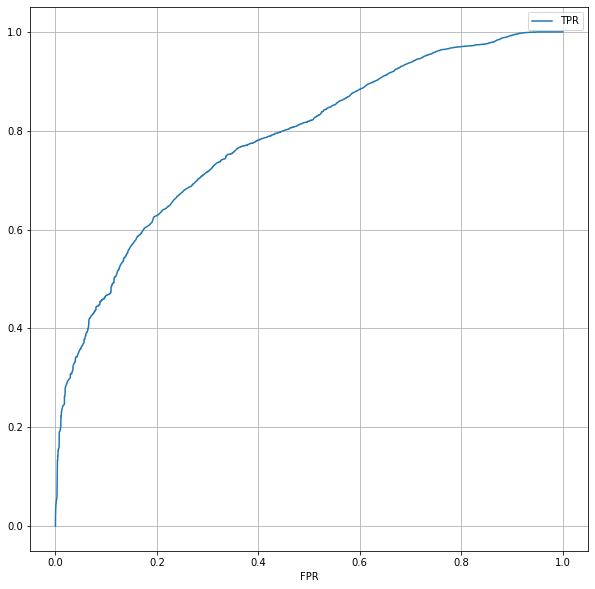

In [112]:
print('f1', test_f1)
ROC_AUC_info(final_model, final_X_test, final_Y_test)

# 6. Расчет окупаемости, рисков и прибыли

##### Фкнцияия расчета тестовой выручки

In [114]:
import math
def test_proffit_calculation(row):
    count_of_cleaning = 1 + row['total_nights'] // 2
    
    expenses_for_cleaning = row['clining_cost'] * count_of_cleaning
    
    
    if row['arrival_date_month'] in ['July', 'August', 'June']:
        revenue = (row['room_price'] * 1.4) * row['total_nights']
        prepayment = 0.8 *  row['room_price'] * 1.4 + row['clining_cost']
        
        if row['predict_cancellation'] == 1 and row['is_canceled'] == 1:
            return -(row['room_price'] * 1.4 + row['clining_cost']) + prepayment
   
        elif row['predict_cancellation'] == 0 and row['is_canceled'] == 1:
            return -((row['room_price'] * 1.4) + row['clining_cost'])

        else:
            return revenue - expenses_for_cleaning
    
    
    elif row['arrival_date_month'] in  ['November', 'October', 'September', 'May', 'April', 'March']:
        revenue = (row['room_price'] * 1.2) * row['total_nights']
        prepayment = 0.8 *  row['room_price'] * 1.2 + row['clining_cost']
        
        if row['predict_cancellation'] == 1 and row['is_canceled'] == 1:
            return -(row['room_price'] * 1.2 + row['clining_cost']) + prepayment
        
        elif row['predict_cancellation'] == 0 and row['is_canceled'] == 1:
            return -((row['room_price'] * 1.2) + row['clining_cost'])
    
        else:
            return revenue - expenses_for_cleaning
            
    else:
        revenue = row['room_price'] * row['total_nights']
        prepayment =  0.8 *  row['room_price'] + row['clining_cost']
        
        if row['predict_cancellation'] == 1 and row['is_canceled'] == 1:
            return -(row['room_price'] + row['clining_cost']) + prepayment
        
        elif row['predict_cancellation'] == 0 and row['is_canceled'] == 1:
            return -(row['room_price'] + row['clining_cost'])
    
        else:
            return revenue - expenses_for_cleaning
    

## 6.1 Таблциа для расчета окупаемости и рисков

In [115]:
payback_data = test_df[['reserved_room_type', 'arrival_date_month', 'total_nights', 'is_canceled', 'arrival_date_year']]
payback_data = payback_data
payback_data['predict_cancellation'] = test_predict
payback_data['room_price'] = payback_data['reserved_room_type'].apply(add_room_price)
payback_data['clining_cost'] = payback_data['reserved_room_type'].apply(add_clining_cost)
payback_data['test_proffit'] = payback_data.apply(test_proffit_calculation, axis=1)

## 6.2 Расчет прибыли за год

In [116]:
revenue = payback_data.loc[payback_data['test_proffit'] >= 0]['test_proffit'].sum()
loss = payback_data.loc[payback_data['test_proffit'] < 0]['test_proffit'].sum()
proffit = payback_data['test_proffit'].sum()

print('выручка = ', revenue)
print('убыток = ', loss)
print('прибыль', proffit)

выручка =  48948060.0
убыток =  -6756956.0
прибыль 42191104.0


## 6.3 расчет риска неокупаемости

##### Функция bootstrap

In [117]:
def revenue_calculation(data):
    return (np.sum(data) - BUDGET)/1000

In [118]:
def bootstrap(data, alpha):
    LEFT_BORDER = 0 + (1 - alpha)/2 
    RIGHT_BORDER = 1 - (1 - alpha)/2
    
    proffit_list = []
    state = state = np.random.RandomState(1234)
    
    for i in range(1000):
        sample_data = data.sample(500, replace=True, random_state = state)
        proffit_list.append(revenue_calculation(sample_data))
        
    left_quantile = np.quantile(proffit_list, LEFT_BORDER)
    right_quantile = np.quantile(proffit_list, RIGHT_BORDER)
    mean_proffit = np.mean(proffit_list)
    
    proffit_list = pd.Series(proffit_list)
    proffit_list.hist()
    
    
    plt.axvline(x=left_quantile, color='r')
    plt.axvline(x=right_quantile, color='r')
    plt.axvline(x=mean_proffit, color='y')
    
    return {'left_quantile': left_quantile, 
            'right_quantile': right_quantile, 
            'mean_proffit': mean_proffit, 
            'proffit_list': proffit_list}

##### Функция расчета риска убытка или неокупаемости

In [119]:
def loss_risk_calculation(data):
    loss_count = data[data <= 0].count()
    loss_probability = loss_count/len(data)
            
    return loss_probability

In [120]:
ALPHA = 0.95
BUDGET = 400_000

<AxesSubplot:>

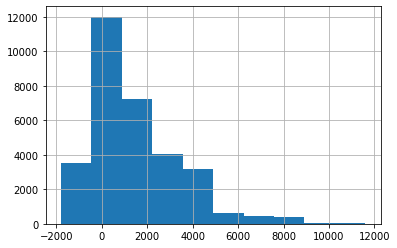

In [121]:
payback_data['test_proffit'].hist()

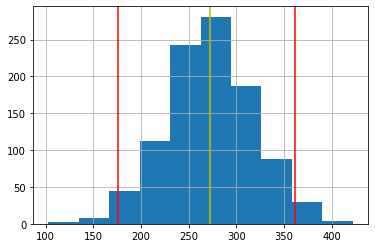

In [122]:
botstrap_results = bootstrap(payback_data['test_proffit'], ALPHA)

In [123]:
for key, value in botstrap_results.items():
    print(key, value)

left_quantile 175.6815
right_quantile 360.90529999999995
mean_proffit 272.372416
proffit_list 0      290.528
1      257.044
2      228.122
3      252.184
4      318.552
        ...   
995    279.926
996    293.358
997    233.930
998    237.484
999    363.904
Length: 1000, dtype: float64


## 6.4 Расчет риска прибыли или неокупаемости

In [124]:
print('Риск убытка или неокупаемости: ', loss_risk_calculation(botstrap_results['proffit_list']))

Риск убытка или неокупаемости:  0.0


#### Вывод

Риск убытка или неокупаемости = 0. С внедрением модели средняя прибыль составит за каждые 500 заказов 360.9

# 7. Портрет «ненадёжного» клиента

In [125]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'importances coef': final_model.feature_importances_
})
feature_importances.sort_values('importances coef', ascending=False)

,Feature,importances coef
10,meal,0.208469
0,lead_time,0.170281
15,previous_bookings_not_canceled,0.170084
18,days_in_waiting_list,0.159681
14,previous_cancellations,0.096791
19,customer_type,0.091199
12,distribution_channel,0.034611
16,reserved_room_type,0.023733
20,required_car_parking_spaces,0.010520
21,total_of_special_requests,0.006494


Для принятия некоторых гипотез не было достаточных оснований из-за отсутвия данных, а именно гипотеза 4, гипотеза 5 и гипотеза 2. Гипотеза 3 подтверждена. Исходя из этого, можно составить следующий портрет «ненадёжного» клиента:<br>
1. У клиента количество дней между бронирование и заселением НЕ равно 0. Чем заранее бронирует клиент, тем он менее надежный<br>
2. У клиента нету ранее отмененных броней<br>
3. Клиент бронирует номер повторно<br>
4. Клиент бронирует номер класса 'E'<br>
<b>Рекомандцаии бизнесу:</b> Обращать внимаение на клиентов у которых большое количестов дней между датой бронирования и прибытем, так как именно клиент с этим признаком больше всего склонен к отмене бронирования

# 8. Общий вывод

Засчет машинного обучения удалсь достичь прибыли в 360.9 за каждые 500 бронированийс 0% риском убытка или неокупаемости.Выявленно поведение ненадежного клиента, даны рекомендации бизнесу